# Figures for the paper

In [1]:
from run_elk import reporter_dir

models = {
    "mistralai/Mistral-7B-v0.1": [
        "08913205",
        44380584,
        75419354,
    ],
    "meta-llama/Llama-2-7b-hf": [
        "None",
        12428270,
        14822214,
    ],
    "EleutherAI/pythia-410m": [
        37112371,
        11665991,
        49386372,
    ],
    "EleutherAI/pythia-1b": [
        81119136,
        41541679,
        43372447,
    ],
    "EleutherAI/pythia-2.8b": [
        53231541,
        59989551,
        81031945,
    ],
}
template_names = ["mixture", "grader_first", "grader_last"]
ccs = True
elk_dir = reporter_dir(ccs)

In [2]:
# <Main figure: x-axis: layer as a percent. y-axis: auroc on disagreements.
# Heavy line averaging over all models and templates, and a faint line for each model-template pair.
# LR, CCS, and best elasticnet in different colors.
# 4x4 figure as follows:
# A->A    A->B  
# B->B    B->A
# >
from collections import defaultdict
from results_utils import measure_across_layers, get_raw_logprobs
import numpy as np

def get_result_dfs(
    fr = "alice",  # probe was trained on this context and against this label set
    to = "bob",  # probe is evaluated on this context
    filter_by = "disagree",  # whether to keep only examples where Alice and Bob disagree
    metric = "auroc",
    p_err = 1.0,
    inlp_iter = 0,
):
    results_dfs = defaultdict(dict)  # (model_name, template_name) -> method -> df
    for base_model in models:
        for version, template in zip(models[base_model], template_names):
            base_model_last = base_model.split("/")[-1]
            def to_fname_mod(name):
                if name == "all":
                    return ""
                return name + "_"
            fr_mod, to_mod = to_fname_mod(fr), to_fname_mod(to)
            method_result_dirs = {
                "LR probe": f"{elk_dir}/{base_model_last}" + "-v{version}/atmallen/qm_{fr}{p_err}e_eval/transfer/atmallen/qm_{to}{p_err}e_eval/logprobs.pt"
            }

            for method, dir_format_str in method_result_dirs.items():
                try:
                    raw_logprobs = get_raw_logprobs(fr_mod, to_mod, p_err=p_err, version=version, dir_template=dir_format_str, verbose=True)
                    print("File found")
                except FileNotFoundError:
                    # print(f"Skipping {base_model} {template} {method} for {fr} {to} {p_err} {version}")
                    # print(f"Couldn't find {dir_format_str.format(fr=fr, to=to, p_err=p_err, version=version)}")
                    # print(f"Run the following command to generate it:")
                    n = (315, 79) if template == "mixture" else (4096, 1024)
                    reverse_map = {
                        "alice": "A",
                        "alice_easy_2": "AE",
                        "alice_hard_4": "AH",
                        "bob": "B",
                        "bob_easy_2": "BE",
                        "bob_hard_4": "BH",
                        "all": "all",
                    }
                    print(f"python run_elk.py --model atmallen/{base_model_last}-v{version} --template {template} --experiment \"{reverse_map[fr]}->{reverse_map[to]}\" --max-examples {n[0]} {n[1]} --num-gpus 7 --fsdp" + (" --ccs" if ccs else ""))
                    continue
                results_df = measure_across_layers(raw_logprobs, "alice", filter_by, "partial", inlp_iter, reporter_key="reporter" if ccs else "lr")
                results_dfs[(base_model, template)][method] = results_df

    layer_fracs = np.linspace(0, 1, 101)
    avg_reporter_results = {method: np.zeros(len(layer_fracs), dtype=np.float32) for method in method_result_dirs}
    avg_lm_results = 0
    for base_model, template_name in results_dfs:
        for method, results_df in results_dfs[(base_model, template_name)].items():    
            # convert `layer` to a fraction of max layer in results_df
            # linearly interpolate to get auroc at each layer_frac

            max_layer = results_df["layer"].max()
            results_df["layer_frac"] = results_df["layer"].values / max_layer

            result = results_df[f"lr_{metric}"].values
            interp_result = np.interp(layer_fracs, results_df["layer_frac"], result)
            avg_reporter_results[method] += interp_result / len(results_dfs)
            lm_result = results_df[f"lm_{metric}"].values
            assert all(np.isclose(r, lm_result[0]) for r in lm_result)
            avg_lm_results += lm_result[0] / (len(results_dfs) * len(method_result_dirs))

    return results_dfs, avg_reporter_results, avg_lm_results, layer_fracs

In [6]:
exps = [("all", "all"), ("all", "bob_hard_4"), ("bob", "bob"), ("bob", "alice")]
rs = dict()
for i, (fr, to) in enumerate(exps):
    results_dfs, avg_reporter_results, avg_lm_results, layer_fracs = get_result_dfs(fr, to, filter_by="all")
    rs[(fr, to)] = (results_dfs, avg_reporter_results, avg_lm_results, layer_fracs)

Loading /root/ccs-reporters/Mistral-7B-v0.1-v08913205/atmallen/qm_1.0e_eval/transfer/atmallen/qm_1.0e_eval/logprobs.pt
python run_elk.py --model atmallen/Mistral-7B-v0.1-v08913205 --template mixture --experiment "all->all" --max-examples 315 79 --num-gpus 7 --fsdp --ccs
Loading /root/ccs-reporters/Mistral-7B-v0.1-v44380584/atmallen/qm_1.0e_eval/transfer/atmallen/qm_1.0e_eval/logprobs.pt
python run_elk.py --model atmallen/Mistral-7B-v0.1-v44380584 --template grader_first --experiment "all->all" --max-examples 4096 1024 --num-gpus 7 --fsdp --ccs
Loading /root/ccs-reporters/Mistral-7B-v0.1-v75419354/atmallen/qm_1.0e_eval/transfer/atmallen/qm_1.0e_eval/logprobs.pt
python run_elk.py --model atmallen/Mistral-7B-v0.1-v75419354 --template grader_last --experiment "all->all" --max-examples 4096 1024 --num-gpus 7 --fsdp --ccs
Loading /root/ccs-reporters/Llama-2-7b-hf-vNone/atmallen/qm_1.0e_eval/transfer/atmallen/qm_1.0e_eval/logprobs.pt
python run_elk.py --model atmallen/Llama-2-7b-hf-vNone --te

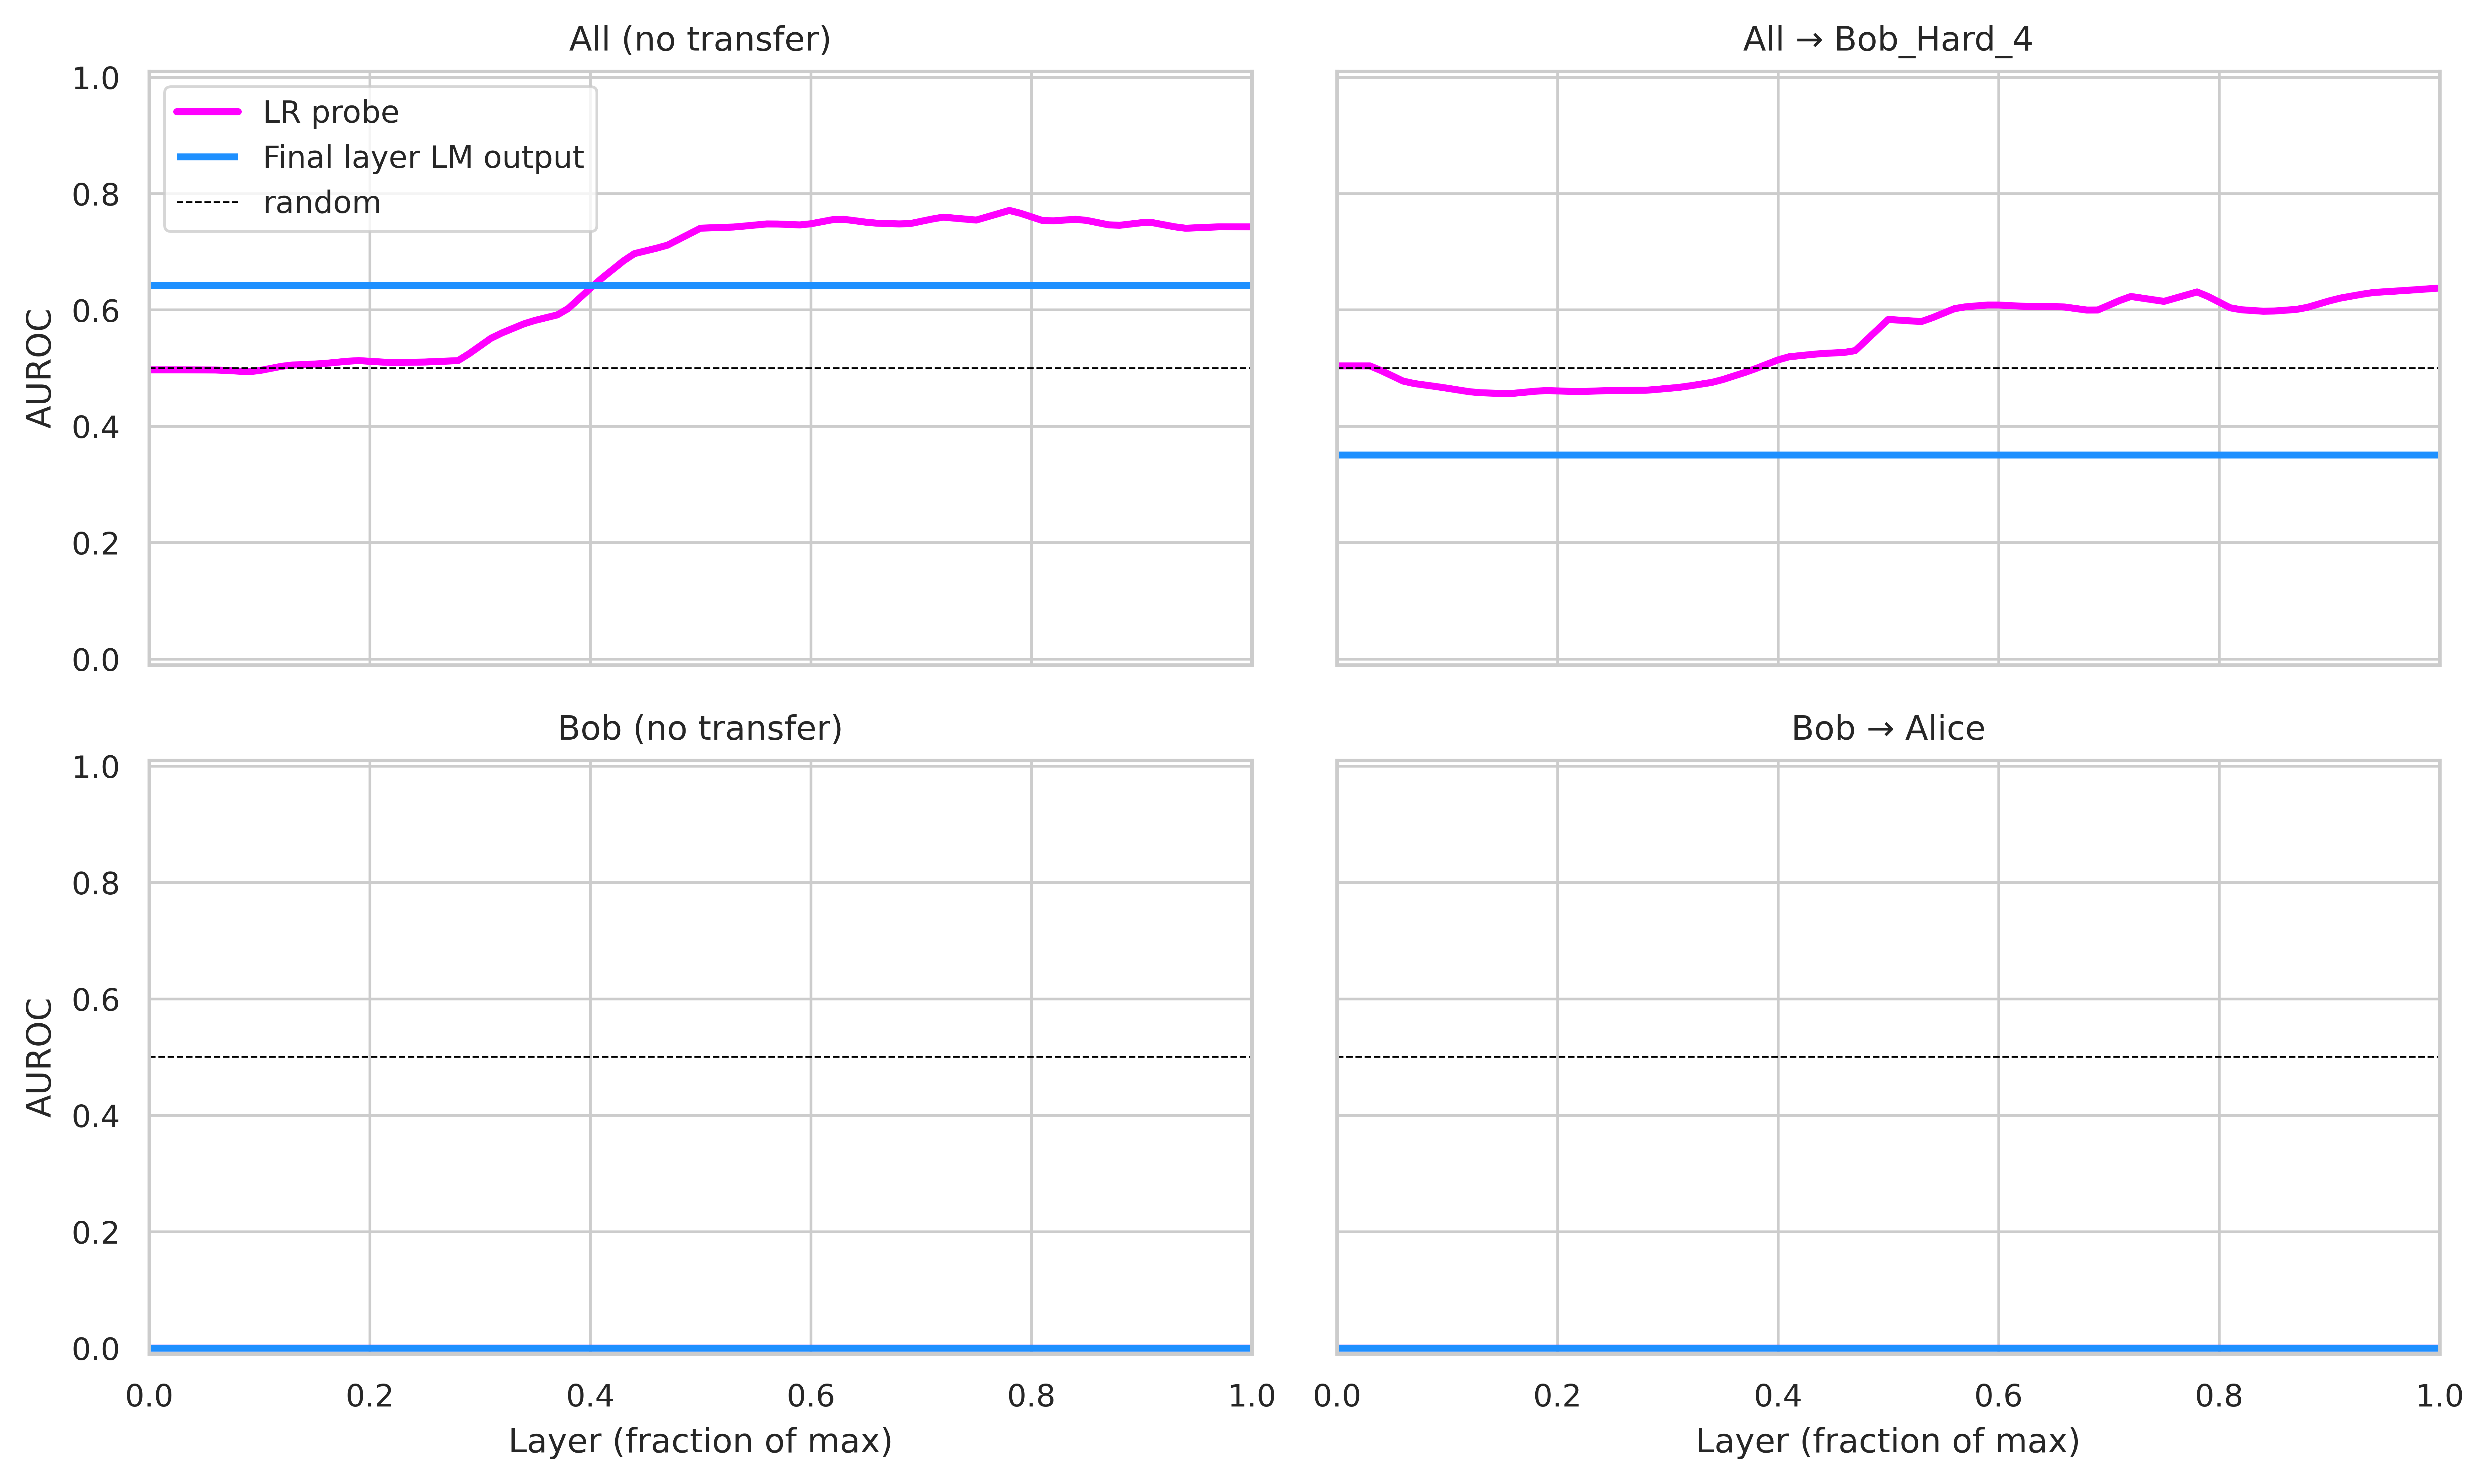

In [5]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

import matplotlib.colors as mcolors

named_colors = list(mcolors.CSS4_COLORS.keys())[20:]

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6), dpi=800)

for i, (fr, to) in enumerate(exps):
    ax = axes[i // 2][i % 2]
    results_dfs, avg_reporter_results, avg_lm_results, layer_fracs = rs[(fr, to)]
    j = 0
    for key in results_dfs:
        for result_df in results_dfs[key].values():
            ax.plot(result_df["layer_frac"], result_df["lr_auroc"], alpha=0.3, color="grey", linewidth=0.5)
            # ax.hlines(result_df["lm_auroc"].iloc[0], 0, 1, alpha=1, color=named_colors[j], linewidth=2, label=str(key))
            j += 1

    for method in avg_reporter_results:
        ax.plot(layer_fracs, avg_reporter_results[method], label=method, linewidth=2, color="fuchsia")

    ax.hlines(avg_lm_results, 0, 1, label="Final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 2 == 0:
        ax.set_ylabel("AUROC")
    if i // 2 == 1: 
        ax.set_xlabel("Layer (fraction of max)")
    if fr == to:
        title = fr.title() + " (no transfer)"
    else:
        title = (f"{fr.title()} → {to.title()}")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.savefig("../figures/layerwise_auroc_AB.pdf")
plt.show()

# Easy to hard generalization

In [ ]:
# <Easy to hard figure: each subplot is as in main figure

# A->AH  AE->AH (all) \\
# A->BH  AE->BH (disagree)
# >
easy_hard_exps = [("alice", "alice_hard_4", "all"), ("alice_easy_2", "alice_hard_4", "all"),
        ("alice", "bob_hard_4", "disagree"), ("alice_easy_2", "bob_hard_4", "disagree")]

easy_hard_rs = dict()
for i, (fr, to, filter_by) in enumerate(easy_hard_exps):
    results_dfs, avg_reporter_results, avg_lm_results, layer_fracs = get_result_dfs(fr, to, filter_by=filter_by)
    easy_hard_rs[(fr, to, filter_by)] = (results_dfs, avg_reporter_results, avg_lm_results, layer_fracs)

python run_elk.py --model atmallen/Mistral-7B-v0.1-v08913205 --template mixture --experiment "A->AH" --max-examples 315 79 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/Mistral-7B-v0.1-v44380584 --template grader_first --experiment "A->AH" --max-examples 4096 1024 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/Mistral-7B-v0.1-v75419354 --template grader_last --experiment "A->AH" --max-examples 4096 1024 --num-gpus 7 --fsdp


python run_elk.py --model atmallen/Llama-2-7b-hf-v12428270 --template grader_first --experiment "A->AH" --max-examples 4096 1024 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/Llama-2-7b-hf-v14822214 --template grader_last --experiment "A->AH" --max-examples 4096 1024 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/pythia-410m-v37112371 --template mixture --experiment "A->AH" --max-examples 315 79 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/pythia-410m-v11665991 --template grader_first --experiment "A->AH" --max-examples 4096 1024 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/pythia-410m-v49386372 --template grader_last --experiment "A->AH" --max-examples 4096 1024 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/pythia-1b-v41541679 --template grader_first --experiment "A->AH" --max-examples 4096 1024 --num-gpus 7 --fsdp
python run_elk.py --model atmallen/pythia-1b-v43372447 --template grader_last --experiment "A->AH" --max-examples 4096 1024 --

NameError: name 'easy_hard_exps' is not defined

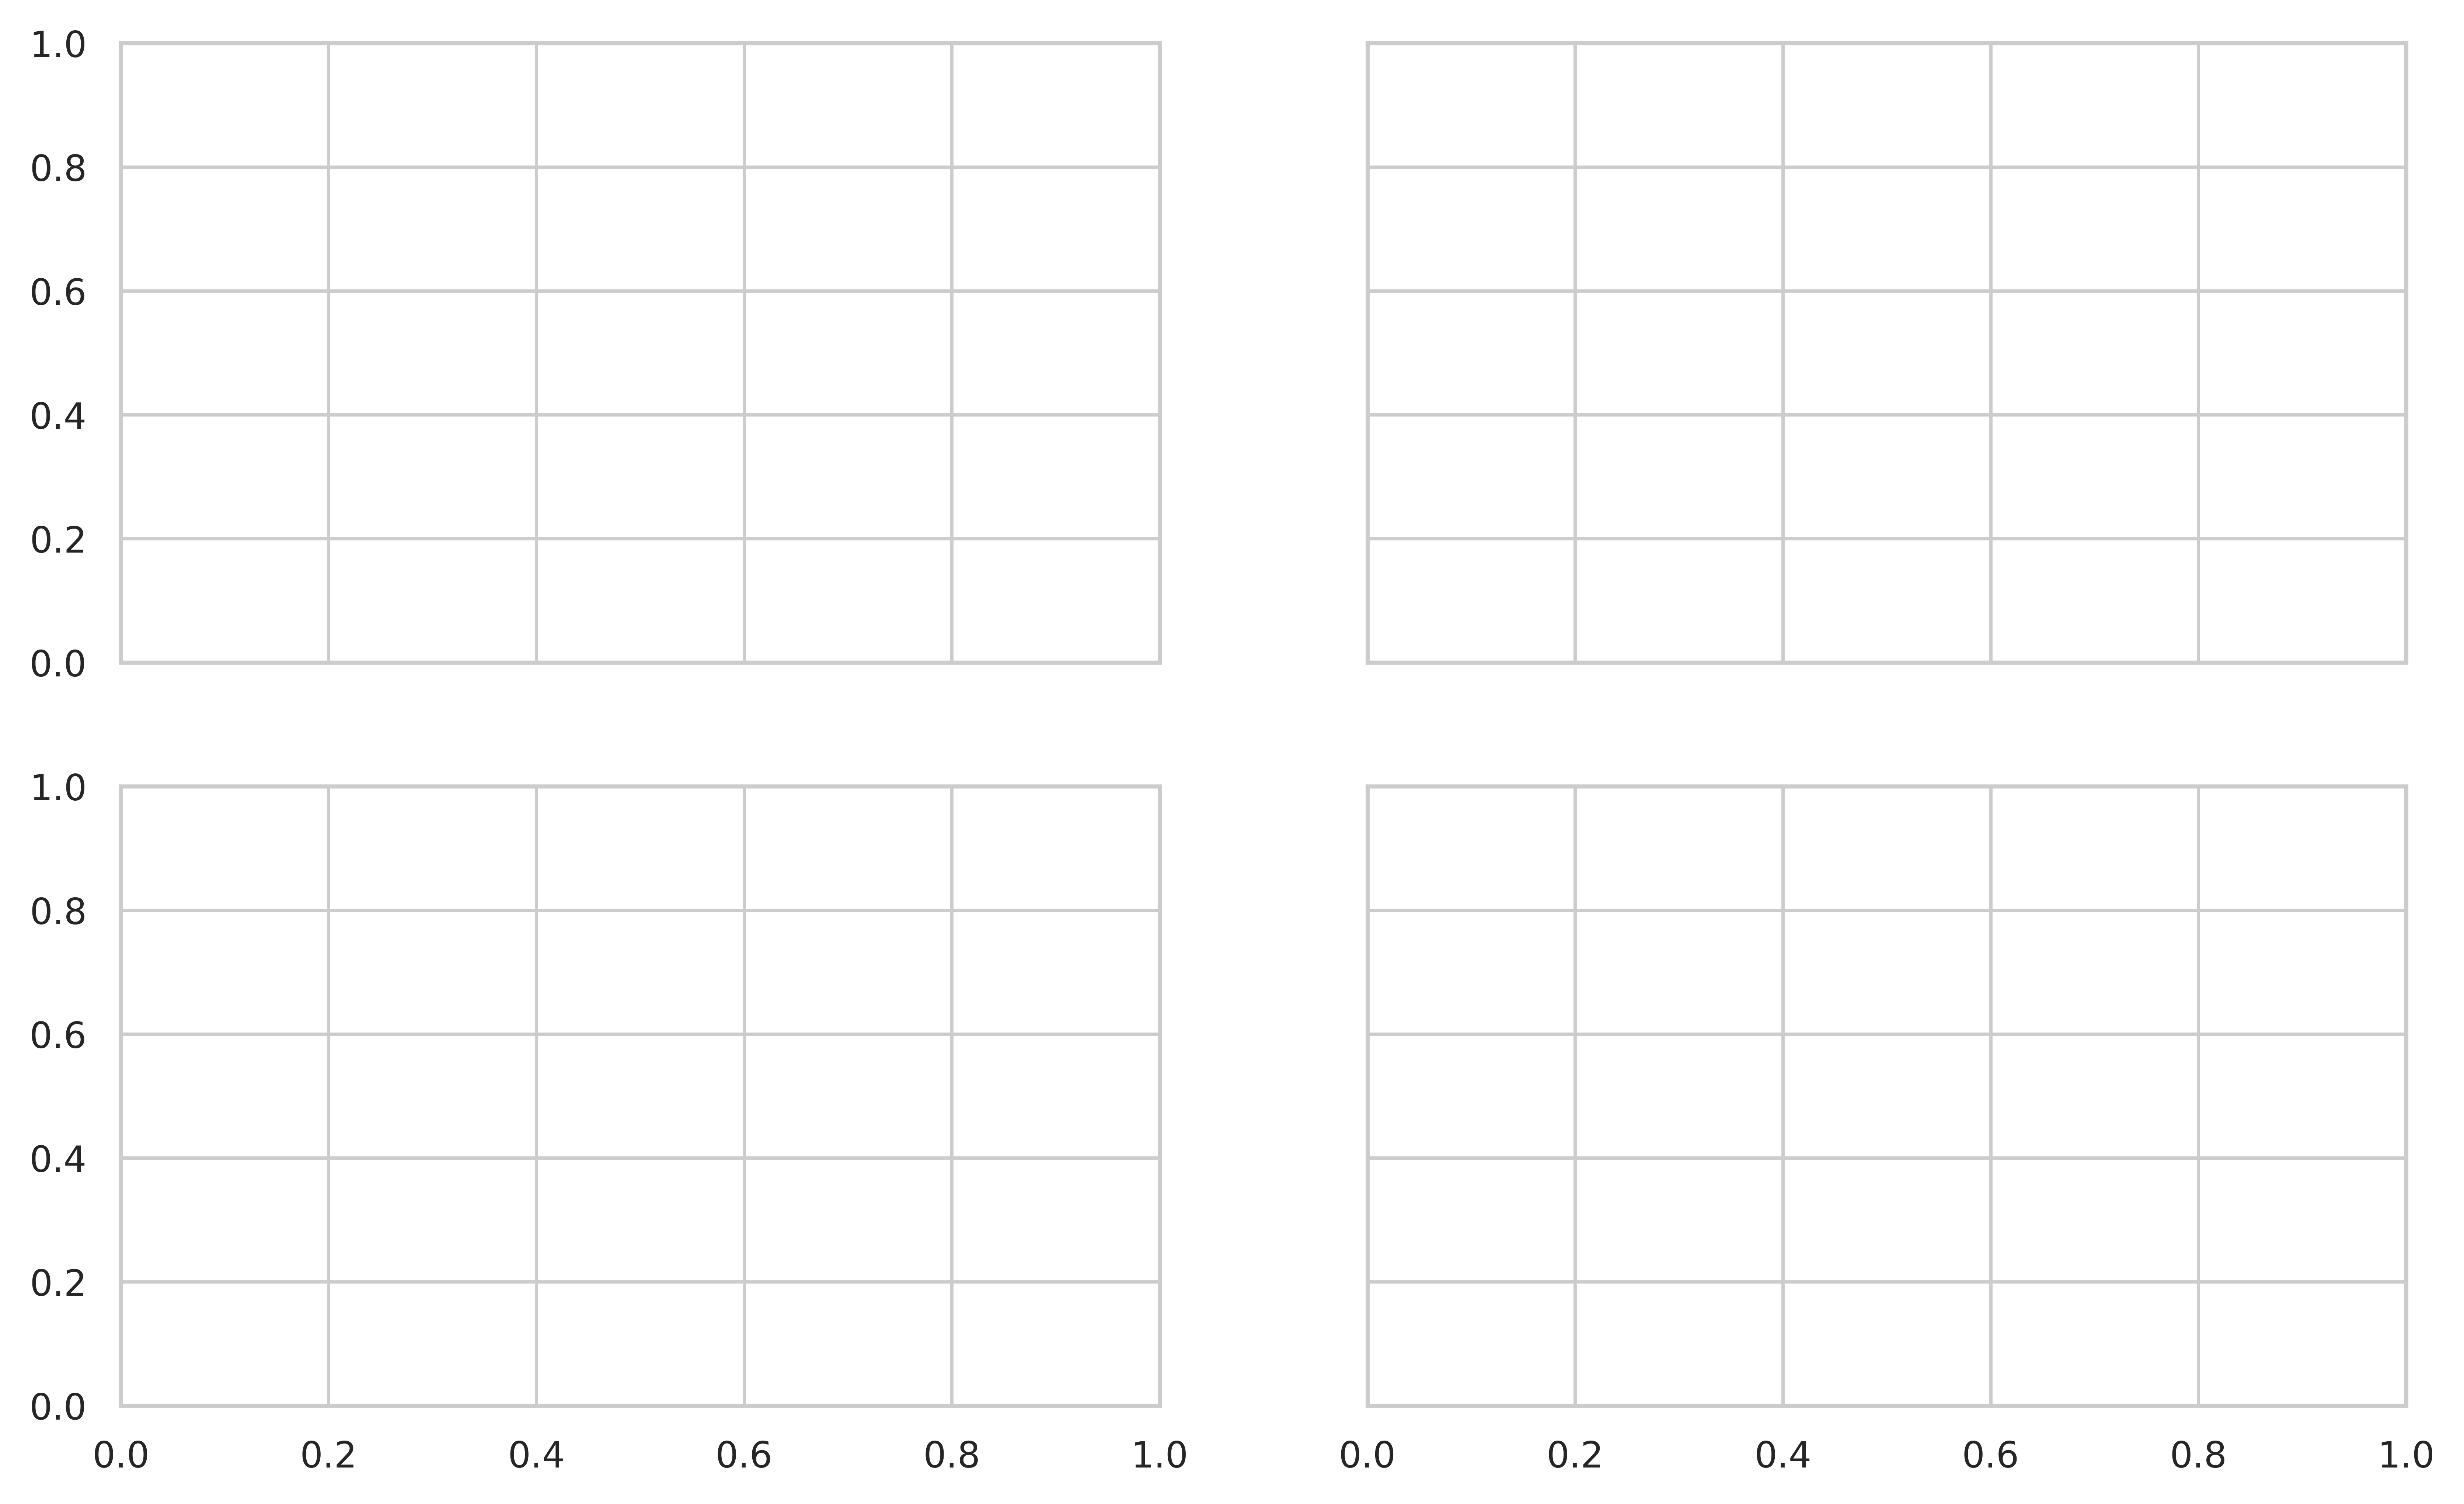

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 6), dpi=800)

for i, (fr, to, filter_by) in enumerate(easy_hard_exps):
    ax = axes[i // 2][i % 2]
    results_dfs, avg_reporter_results, avg_lm_results, layer_fracs = easy_hard_rs[(fr, to, filter_by)]
    for key in results_dfs:
        for result_df in results_dfs[key].values():
            ax.plot(result_df["layer_frac"], result_df["lr_auroc"], alpha=0.3, color="grey", linewidth=0.5)

    for method in avg_reporter_results:
        ax.plot(layer_fracs, avg_reporter_results[method], label=method, linewidth=2, color="fuchsia")

    ax.hlines(avg_lm_results, 0, 1, label="Final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 2 == 0:
        ylabel = "AUROC on $\\bf{all}$ examples" if filter_by == "all" else "AUROC on $\\bf{disagreements}$ "
        ax.set_ylabel(ylabel)
    if i // 2 == 1: 
        ax.set_xlabel("Layer (fraction of max)")
    clean = lambda s: s.replace("_2", "").replace("_4", "").replace("_", " ")
    fr = clean(fr)
    to = clean(to)
    if fr == to:
        title = fr.title() + " (no transfer)"
    else:
        title = (f"{fr.title()} → {to.title()}")
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.savefig("../figures/layerwise_auroc_EH.pdf")
plt.show()